<a href="https://colab.research.google.com/github/dyna-bytes/PyTorchIntensive/blob/main/5_5_2_RNN_Model_Design(MNIST_RNN2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'[{_str}]:')
        _str = ''
    if type(var)!=type([]):
        try:
            print(f'Shape:{var.shape}')
        except :
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}')

In [ ]:
%%capture
!pip install pytorch_lightning torchinfo torchmetrics pandas torchviz

## RNN Model Design (MNIST-RNN)

### **Import Module**

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics import functional as FM
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.5]

device = 'cuda:0'
torch.__version__

'2.0.1+cu118'

### **DataSet**

#### Load

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
])

from torchvision.datasets import MNIST

# download path 정의
download_root = './MNIST_DATASET'

train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 99120769.69it/s]


Extracting ./MNIST_DATASET/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 117836278.04it/s]


Extracting ./MNIST_DATASET/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25170296.68it/s]


Extracting ./MNIST_DATASET/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2809812.50it/s]


Extracting ./MNIST_DATASET/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw



In [ ]:
# option 값 정의
batch_size = 256

train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

In [ ]:
ps(train_dataset[0][0],'image'),p(train_dataset[0][1],'label')

[image] Shapetorch.Size([1, 28, 28])
[label]:
Type: <class 'int'>
Values: 5


(None, None)

In [ ]:
ps(next(iter(train_loader))[0])

[] Shapetorch.Size([256, 1, 28, 28])


### **Model-3 : Hierachical RNN model**


#### Model Define

In [ ]:
# 주요 변수 정의
pixel = 1          ## features
pixels = 28        ## pixels
lines = 28         ## lines
chennels = 1       ## b/w = 1
lstm1_units = 50    #50 임의 값
lstm2_units = 16   # 임의 값
out_dense = 10   # 출력은 숫자(0~9) 확률

In [ ]:
class HierachicalRNN(pl.LightningModule):
    def __init__(self, pixel, lstm1_units, lstm2_units, out_dense, batch_first=True):
        super(HierachicalRNN, self).__init__()
        self.timeDistributed_LSTM = nn.LSTM(input_size=pixel, hidden_size=lstm1_units,
                                            batch_first=batch_first)
        self.lstm = nn.LSTM(input_size=lstm1_units, hidden_size=lstm2_units,
                                            batch_first=batch_first)
        self.outLinear = nn.Linear(lstm2_units, out_dense)

    def forward(self, x):
        # x1:([512, 28p, 1]) <- x:([512, 1, 28l, 28p])
        x1 = x[:,0,0,:].reshape(x.size(0),-1,1)
        y = self.timeDistributed_LSTM(x1) #([512, 28, 50])
        y = y[0][:,-1,:] #(512,50)
        y = y.view(x.size(0),1,-1) #(512,1,50)
        for i in range(x.size()[2]-1):
          x1 = x[:,0,i+1,:].reshape(x.size(0),-1,1)
          y1 = self.timeDistributed_LSTM(x1)
          y1 = y1[0][:,-1,:] #(512,50)
          y1 = y1.view(x.size(0),1,-1) #(512,1,50)
          y = torch.cat((y, y1),dim=1)
        #y: ([512, 28, 50])
        out, (hn, cn) = self.lstm(y) #(512,28,16)
        out = self.outLinear(out[:, -1, :]) #(512,10)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = self.to(device)(x)
        y = y.squeeze(dim=-1)
        loss = F.cross_entropy(y_hat, y)
        acc = FM.accuracy(y_hat, y,task='multiclass',num_classes=10 )
        metrics = {'loss':loss, 'acc':acc}
        self.log_dict(metrics,on_step=False,on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(device), y.to(device)
        logits = self.to(device)(x)
        y = y.squeeze(dim=-1)
        loss = F.cross_entropy(logits, y)
        acc = FM.accuracy(logits, y.long(),task='multiclass',num_classes=10 )
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics,on_step=False,on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

model = HierachicalRNN(pixel, lstm1_units, lstm2_units, out_dense).to(device)
summary(model, input_size=(batch_size, chennels, lines, pixels)) #(bs,1,28,28)

Layer (type:depth-idx)                   Output Shape              Param #
HierachicalRNN                           [256, 10]                 --
├─LSTM: 1-1                              [256, 28, 50]             10,600
├─LSTM: 1-2                              [256, 28, 50]             (recursive)
├─LSTM: 1-3                              [256, 28, 50]             (recursive)
├─LSTM: 1-4                              [256, 28, 50]             (recursive)
├─LSTM: 1-5                              [256, 28, 50]             (recursive)
├─LSTM: 1-6                              [256, 28, 50]             (recursive)
├─LSTM: 1-7                              [256, 28, 50]             (recursive)
├─LSTM: 1-8                              [256, 28, 50]             (recursive)
├─LSTM: 1-9                              [256, 28, 50]             (recursive)
├─LSTM: 1-10                             [256, 28, 50]             (recursive)
├─LSTM: 1-11                             [256, 28, 50]             (re

In [ ]:
!pip install onnx
torch.onnx.export(model, torch.zeros((batch_size, chennels, lines, pixels)).to(device), 'Mnist_Rnn_HierachicalRNN.onnx')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 97.0 MB/s eta 0:00:00
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



RuntimeError: ignored

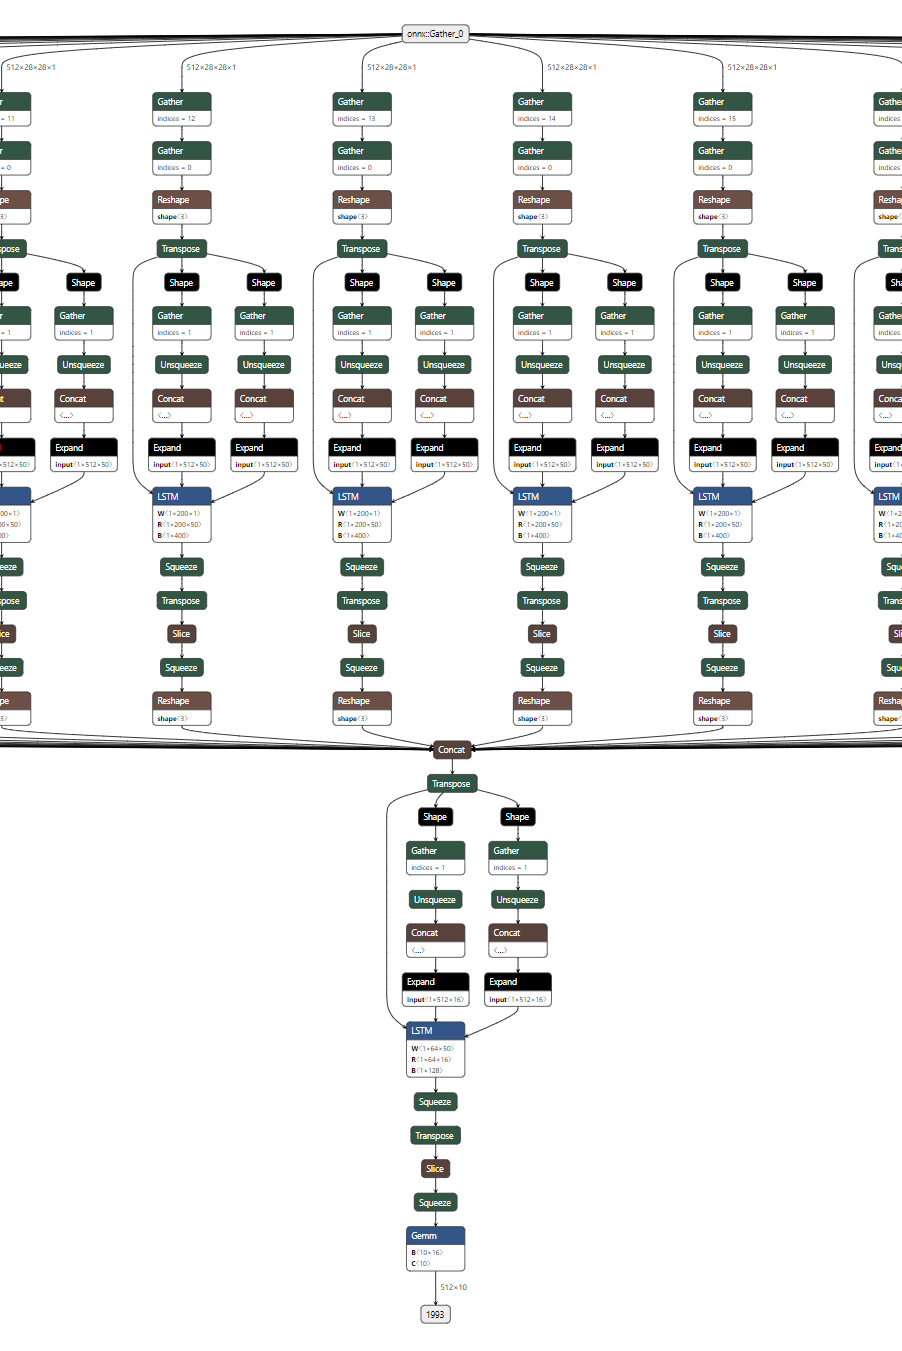

#### Fit

In [ ]:
%%time
trainer = Trainer(max_epochs=15,accelerator='auto',
                  limit_train_batches=0.2, limit_val_batches=0.2 )
trainer.fit(model, train_loader, test_loader)

Epoch 14: 100%
548/548 [00:17<00:00, 31.89it/s, loss=0.164, v_num=3, val_loss=0.143, val_acc=0.956]
CPU times: user 4min 27s, sys: 1.85 s, total: 4min 29s
Wall time: 4min 39s

#### **Analysis**

##### Plot

In [ ]:
# model train_logdir 확인
v_num = model.logger.version
log_dir = f'lightning_logs/version_{v_num}'

event_accumulator = EventAccumulator(log_dir)
event_accumulator.Reload()

train_loss = [x.value for x in event_accumulator.Scalars('loss')]
train_lstep = [x.step for x in event_accumulator.Scalars('loss')]
val_loss = [x.value for x in event_accumulator.Scalars('val_loss')]
val_lstep = [x.step for x in event_accumulator.Scalars('val_loss') ]
val_acc = [x.value for x in event_accumulator.Scalars('val_acc') ]
val_astep = [x.step for x in event_accumulator.Scalars('val_acc') ]

print('Max val_acc : ',np.max(val_acc))

plt.plot(train_lstep, train_loss, linestyle='--', label="train_loss")
plt.plot(val_lstep, val_loss, linestyle='--', label="val_loss")
plt.plot(val_astep, val_acc, linestyle='--', label="val_acc")

plt.ylim(0.1, 1)
#plt.semilogy()
plt.legend()
plt.grid()
plt.show()

Max val_acc :  0.963699996471405
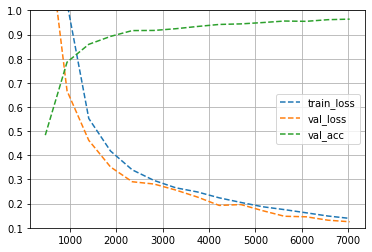

### ***실습 과제***

##### 과제 1. Model_3 변형 : LSTM_1의 units이 적절할까? 너무 큰것 아닐까?
###### -- 줄여보자.
###### -- 최적의 units이 얼마일까? 최적인 이유는?
###### -- Parameter의 수의 차이도 확인해 보자
##### 과제 2. 수정된 모델에서 : LSTM2의 seq. 출력을 모두 사용하려면 어떻게 해야 할까?
##### 과제 3. 몇개의 line을 보면 글자를 알아 맞출수 있을까? 글자마다 다를까?
###### -- line별 weight를 통해 중요도를 시각화 해 보자
###### -- 글자별로 어떤 차이가 있는지 확인해 보자

#### 과제 1


#### Model Define

In [ ]:
# 주요 변수 재정의
lstm1_units = 16   #50 임의 값
lstm2_units = 16   # 임의 값

In [ ]:
class HierachicalRNN(pl.LightningModule):
    def __init__(self, pixel, lstm1_units, lstm2_units, out_dense, batch_first=True):
        super(HierachicalRNN, self).__init__()
        self.timeDistributed_LSTM = nn.LSTM(input_size=pixel, hidden_size=lstm1_units,
                                            batch_first=batch_first)
        self.lstm = nn.LSTM(input_size=lstm1_units, hidden_size=lstm2_units,
                                            batch_first=batch_first)
        self.outLinear = nn.Linear(lstm2_units, out_dense)

    def forward(self, x):
        # x1:([512, 28p, 1]) <- x:([512, 1, 28l, 28p])
        x1 = x[:,0,0,:].reshape(x.size(0),-1,1)
        y = self.timeDistributed_LSTM(x1) #([512, 28, 50])
        y = y[0][:,-1,:] #(512,50)
        y = y.view(x.size(0),1,-1) #(512,1,50)
        for i in range(x.size()[2]-1):
          x1 = x[:,0,i+1,:].reshape(x.size(0),-1,1)
          y1 = self.timeDistributed_LSTM(x1)
          y1 = y1[0][:,-1,:] #(512,50)
          y1 = y1.view(x.size(0),1,-1) #(512,1,50)
          y = torch.cat((y, y1),dim=1)
        #y: ([512, 28, 50])
        out, (hn, cn) = self.lstm(y) #(512,28,16)
        out = self.outLinear(out[:, -1, :]) #(512,10)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = self.to(device)(x)
        y = y.squeeze(dim=-1)
        loss = F.cross_entropy(y_hat, y)
        acc = FM.accuracy(y_hat, y,task='multiclass',num_classes=10 )
        metrics = {'loss':loss, 'acc':acc}
        self.log_dict(metrics,on_step=False,on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(device), y.to(device)
        logits = self.to(device)(x)
        y = y.squeeze(dim=-1)
        loss = F.cross_entropy(logits, y)
        acc = FM.accuracy(logits, y.long(),task='multiclass',num_classes=10 )
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics,on_step=False,on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

model = HierachicalRNN(pixel, lstm1_units, lstm2_units, out_dense).to(device)
summary(model, input_size=(batch_size, chennels, lines, pixels)) #(bs,1,28,28)

Layer (type:depth-idx)                   Output Shape              Param #
HierachicalRNN                           [256, 10]                 --
├─LSTM: 1-1                              [256, 28, 16]             1,216
├─LSTM: 1-2                              [256, 28, 16]             (recursive)
├─LSTM: 1-3                              [256, 28, 16]             (recursive)
├─LSTM: 1-4                              [256, 28, 16]             (recursive)
├─LSTM: 1-5                              [256, 28, 16]             (recursive)
├─LSTM: 1-6                              [256, 28, 16]             (recursive)
├─LSTM: 1-7                              [256, 28, 16]             (recursive)
├─LSTM: 1-8                              [256, 28, 16]             (recursive)
├─LSTM: 1-9                              [256, 28, 16]             (recursive)
├─LSTM: 1-10                             [256, 28, 16]             (recursive)
├─LSTM: 1-11                             [256, 28, 16]             (rec

#### Fit

In [ ]:
%%time
trainer = Trainer(max_epochs=15,accelerator='auto',
                  limit_train_batches=1.0, limit_val_batches=0.5 )
trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type   | Params
------------------------------------------------
0 | timeDistributed_LSTM | LSTM   | 1.2 K 
1 | lstm                 | LSTM   | 2.2 K 
2 | outLinear            | Linear | 170   
------------------------------------------------
3.6 K     Trainable params
0         Non-trainable params
3.6 K     Total params
0.014     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


CPU times: user 3min 54s, sys: 886 ms, total: 3min 55s
Wall time: 3min 58s


#### **Analysis**

##### Plot

In [ ]:
log = {}

Max val_acc :  0.9228515625


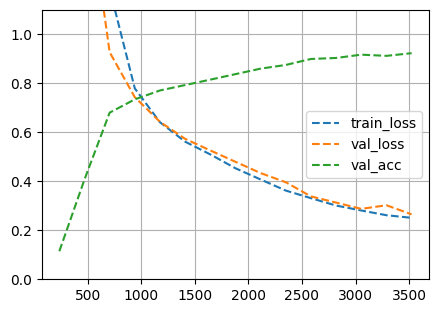

In [ ]:
# model train_logdir 확인
v_num = model.logger.version
log_dir = f'lightning_logs/version_{v_num}'

event_accumulator = EventAccumulator(log_dir)
event_accumulator.Reload()

train_loss = [x.value for x in event_accumulator.Scalars('loss')]
train_lstep = [x.step for x in event_accumulator.Scalars('loss')]
val_loss = [x.value for x in event_accumulator.Scalars('val_loss')]
val_lstep = [x.step for x in event_accumulator.Scalars('val_loss') ]
val_acc = [x.value for x in event_accumulator.Scalars('val_acc') ]
val_astep = [x.step for x in event_accumulator.Scalars('val_acc') ]

print('Max val_acc : ',np.max(val_acc))

plt.plot(train_lstep, train_loss, linestyle='--', label="train_loss")
plt.plot(val_lstep, val_loss, linestyle='--', label="val_loss")
plt.plot(val_astep, val_acc, linestyle='--', label="val_acc")

plt.ylim(0, 1.1)
#plt.semilogy()
plt.legend()
plt.grid()
plt.show()

Max val_acc :  0.9749000072479248
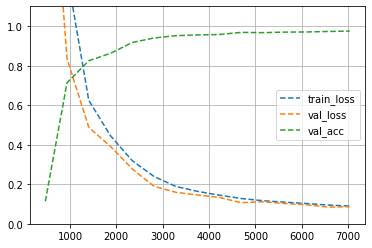